# Demonstration of Bayesian QNM Fits

This is a tutorial / demonstration of the main functions used in this code. 

## Basic likelihood (amplitudes only) 

In [13]:
import qnmfits
import numpy as np
import scipy
import corner
from funcs.likelihood_funcs import *
from funcs.CCE import * 
from funcs.kernel_param_funcs import *
from funcs.GP_funcs import *

We start by importing a simulation (as a qnmfits.Custom object). We obtain the remnant mass and spin (which we denote with _0 in code and as a subscript * in the written notes). We also choose a start time for the fit, and modes to include in the model.  

In [14]:
id = "0001"

sim_main = SXS_CCE(id, lev="Lev5", radius="R2")

n_max = 6

T0 = 50
T = 100

qnm_list = [(2,2,n,1) for n in np.arange(0, n_max+1)]
spherical_modes = [(2, 2)]

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

Next, we determine the least squared amplitudes. The C_0 list can be used when we include Mf and/or Chif as parameters (otherwise it isn't needed). We hereafter treat the real and imaginary QNM amplitude as separate parameters, included in sequence in the true_params list. 

In [15]:
ls_fit = qnmfits.multimode_ringdown_fit(
    sim.times,
    sim.h,
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=t0,
    T=100,
    spherical_modes=spherical_modes,
)

C_0 = ls_fit["C"]

true_params = []
for re_c, im_c in zip(np.real(ls_fit["C"]), np.imag(ls_fit["C"])):
    true_params.append(re_c)
    true_params.append(im_c)

The kernel parameters are pre-saved in the tuned_params file. However, for the white noise, these need to be computed using the tuned value. 

In [ ]:
# Get the standard kernel parameters

with open('tuned_params.pkl', 'rb') as f:
    params = pickle.load(f)

tuned_param_dict_main = params[id]

In [17]:
# This is just for the white noise kernel because I don't auto generate a file 

with open('param_dict_sim_lm_full.pkl', 'rb') as f:
    param_dict_sim_lm = pickle.load(f)

tuning_hyperparams_s = [0.3996582031249995]  

hyperparam_rule_dict_s = {
    "sigma_max": "multiply",
}

tuned_param_dict_wn = {mode: get_new_params(param_dict_sim_lm[id][mode], tuning_hyperparams_s, hyperparam_rule_dict_s) for mode in param_dict_sim_lm[id]}

We now use the QNM BGP fit to do the least squares fit with our chosen kernel

In [18]:
# White noise kernel

fit_wn = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_wn,
        kernel_s,
        t0_method="geq",
        T=T,
        spherical_modes=spherical_modes,
    )

# Standard kernel 

fit_main = qnm_BGP_fit(
        sim_main.times,
        sim_main.h,
        qnm_list,
        Mf_0,
        chif_mag_0,
        T0,
        tuned_param_dict_main,
        kernel_main,
        t0_method="geq",
        T=T,
        spherical_modes=spherical_modes,
    )

KeyError: (2, 2)

As a quick check, we can compare the mean vector to the least squares values.  

In [ ]:
print("Mean vector: ", list(mean_vector))
print("Least squares amplitudes :", true_params)
print("Similar?", np.allclose(mean_vector, true_params, rtol=1e-2))

Mean vector:  [0.050099778660717305, 0.17091426110828095, 0.018390127761825262, -0.009129956210055629, -0.002230371288623896, -0.01016695245022471, 0.001210188878311687, 0.005390749420265272]
Least squares amplitudes : [0.05009704238626304, 0.1709098151146639, 0.018435229844421277, -0.009069259796711615, -0.002379721032302372, -0.01033663558789805, 0.0013364735076800286, 0.00551541924162394]
Similar? False


Finally, we take some samples from a multivariate normal and plot these. 

In [ ]:
samples = scipy.stats.multivariate_normal(
    mean_vector, covariance_matrix, allow_singular=True
).rvs(size=10000)

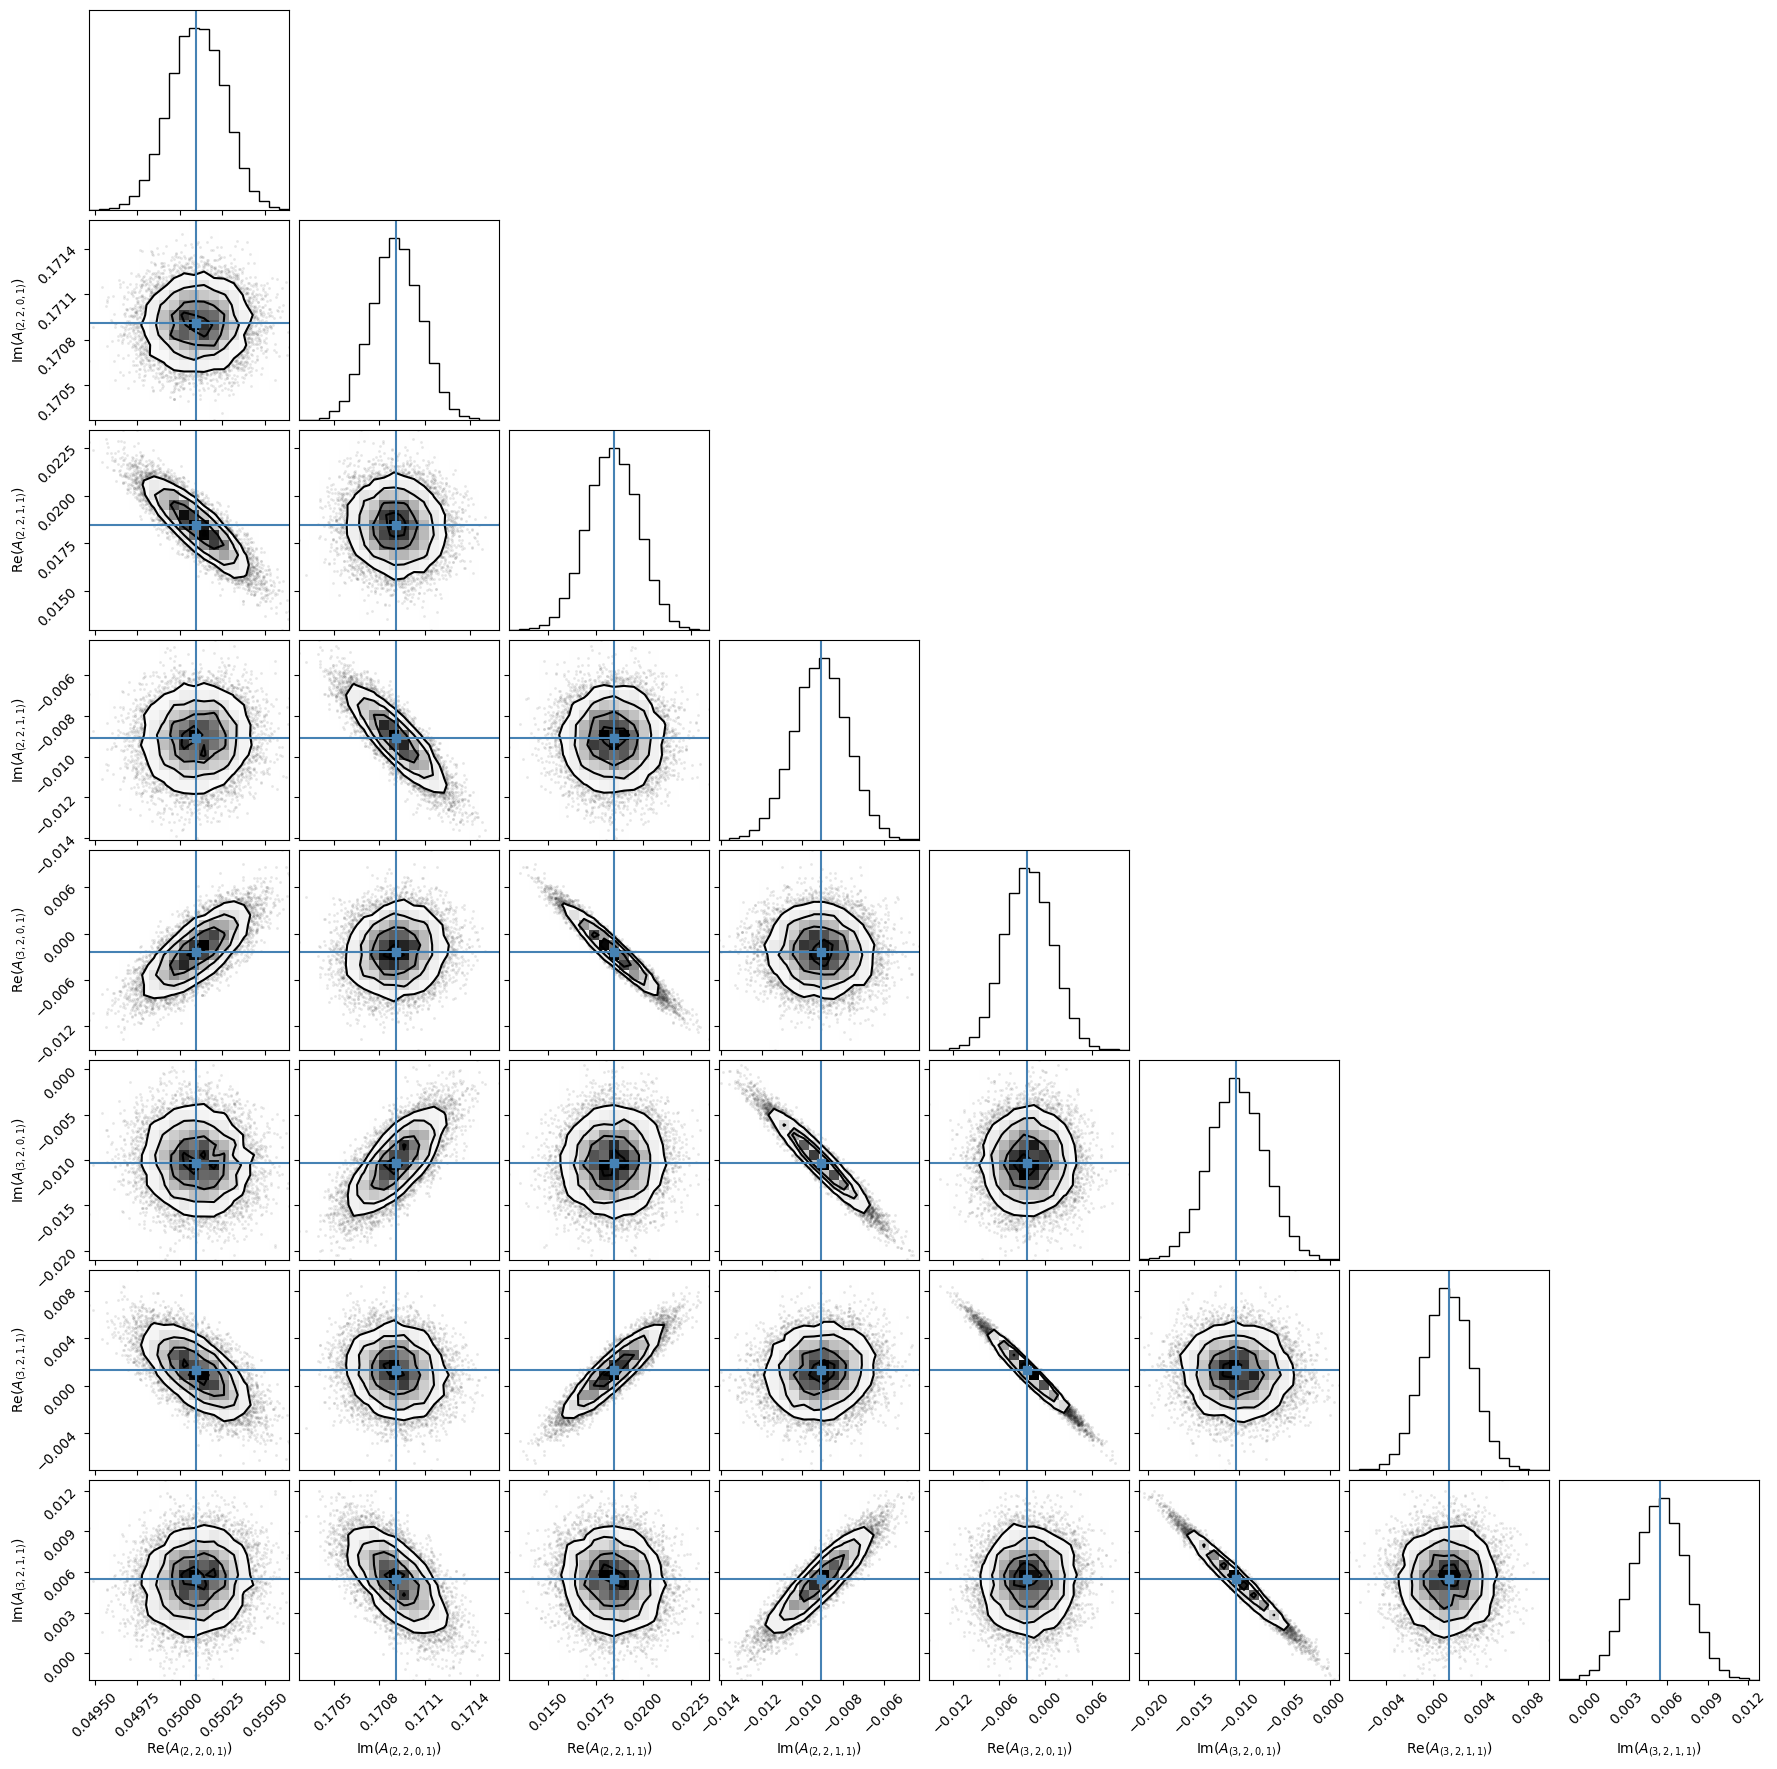

In [ ]:
labels = [
    r"$\mathrm{Re}(A_{(2,2,0,1)})$",
    r"$\mathrm{Im}(A_{(2,2,0,1)})$",
    r"$\mathrm{Re}(A_{(2,2,1,1)})$",
    r"$\mathrm{Im}(A_{(2,2,1,1)})$",
    r"$\mathrm{Re}(A_{(3,2,0,1)})$",
    r"$\mathrm{Im}(A_{(3,2,0,1)})$",
    r"$\mathrm{Re}(A_{(3,2,1,1)})$",
    r"$\mathrm{Im}(A_{(3,2,1,1)})$",
]

_ = corner.corner(
    samples,
    truths=true_params,
    labels=labels,
)

## Basic likelihood (mass and spin included) 

We can also include the mass and spin as parameters in the model. In practise they are included as the final two elements in parameter lists:

$[\rm Re(A_1), \rm Im(A_1), \rm Re(A_2), \rm Im(A_2), \dots, \chi_f, M_f]$.

To include these, set the appropriate boolean arguments in get_fisher_matrix, get_b_vector. C_0 also needs to be set to the the list obtained from the least-squares fit, and the true_param values need to be added to the mean vector.  The reason for avoiding these in the amplitude-only case is to save us having to compute the least-squares fit (because, in this case, only $M_*$ and $\chi_*$ are needed). 


In [ ]:
true_params_full = true_params + [chif_mag_0, Mf_0]

In [ ]:
fisher_matrix = likelihood_funcs.get_fisher_matrix(
    qnm_list,
    spherical_modes,
    data_times,
    Mf_0,
    chif_mag_0,
    inv_cov=sigma,
    C_0=C_0,
    include_chif=True,
    include_Mf=True,
)
b_vec = likelihood_funcs.get_b_vector(
    qnm_list,
    spherical_modes,
    t0,
    data_times,
    data,
    Mf_0,
    chif_mag_0,
    inv_cov=sigma,
    C_0=C_0,
    include_chif=True,
    include_Mf=True,
)

TypeError: get_fisher_matrix() missing 1 required positional argument: 'chif_mag_0'

In [ ]:
mean_vector = np.linalg.solve(fisher_matrix, b_vec) + true_params_full
covariance_matrix = np.linalg.inv(fisher_matrix)

Note that we no longer expect the mean vector to precisely return the least squares values. 

In [ ]:
print("Mean vector: ", list(mean_vector))
print("Least squares parameters :", true_params_full)
print("Similar?", np.allclose(mean_vector, true_params_full, rtol=1e-1))

Mean vector:  [0.05051635708634439, 0.17110190600487155, 0.017606116616881745, -0.014067824839881699, 0.004860781690431463, 0.002697687714123098, 0.00021008797443635333, -0.0009878303952482032, 0.6859246630341682, 0.9515647597420978]
Least squared parameters : [0.04999498008327843, 0.17118601661192326, 0.01824576942307358, -0.0141760953067477, 0.00486003091433753, 0.0027069114229464892, 0.00021066388117355322, -0.001002205201381146, 0.686441921316848, 0.9516192579333816]
Similar? True


In [ ]:
samples = scipy.stats.multivariate_normal(
    mean_vector, covariance_matrix, allow_singular=True
).rvs(size=10000)

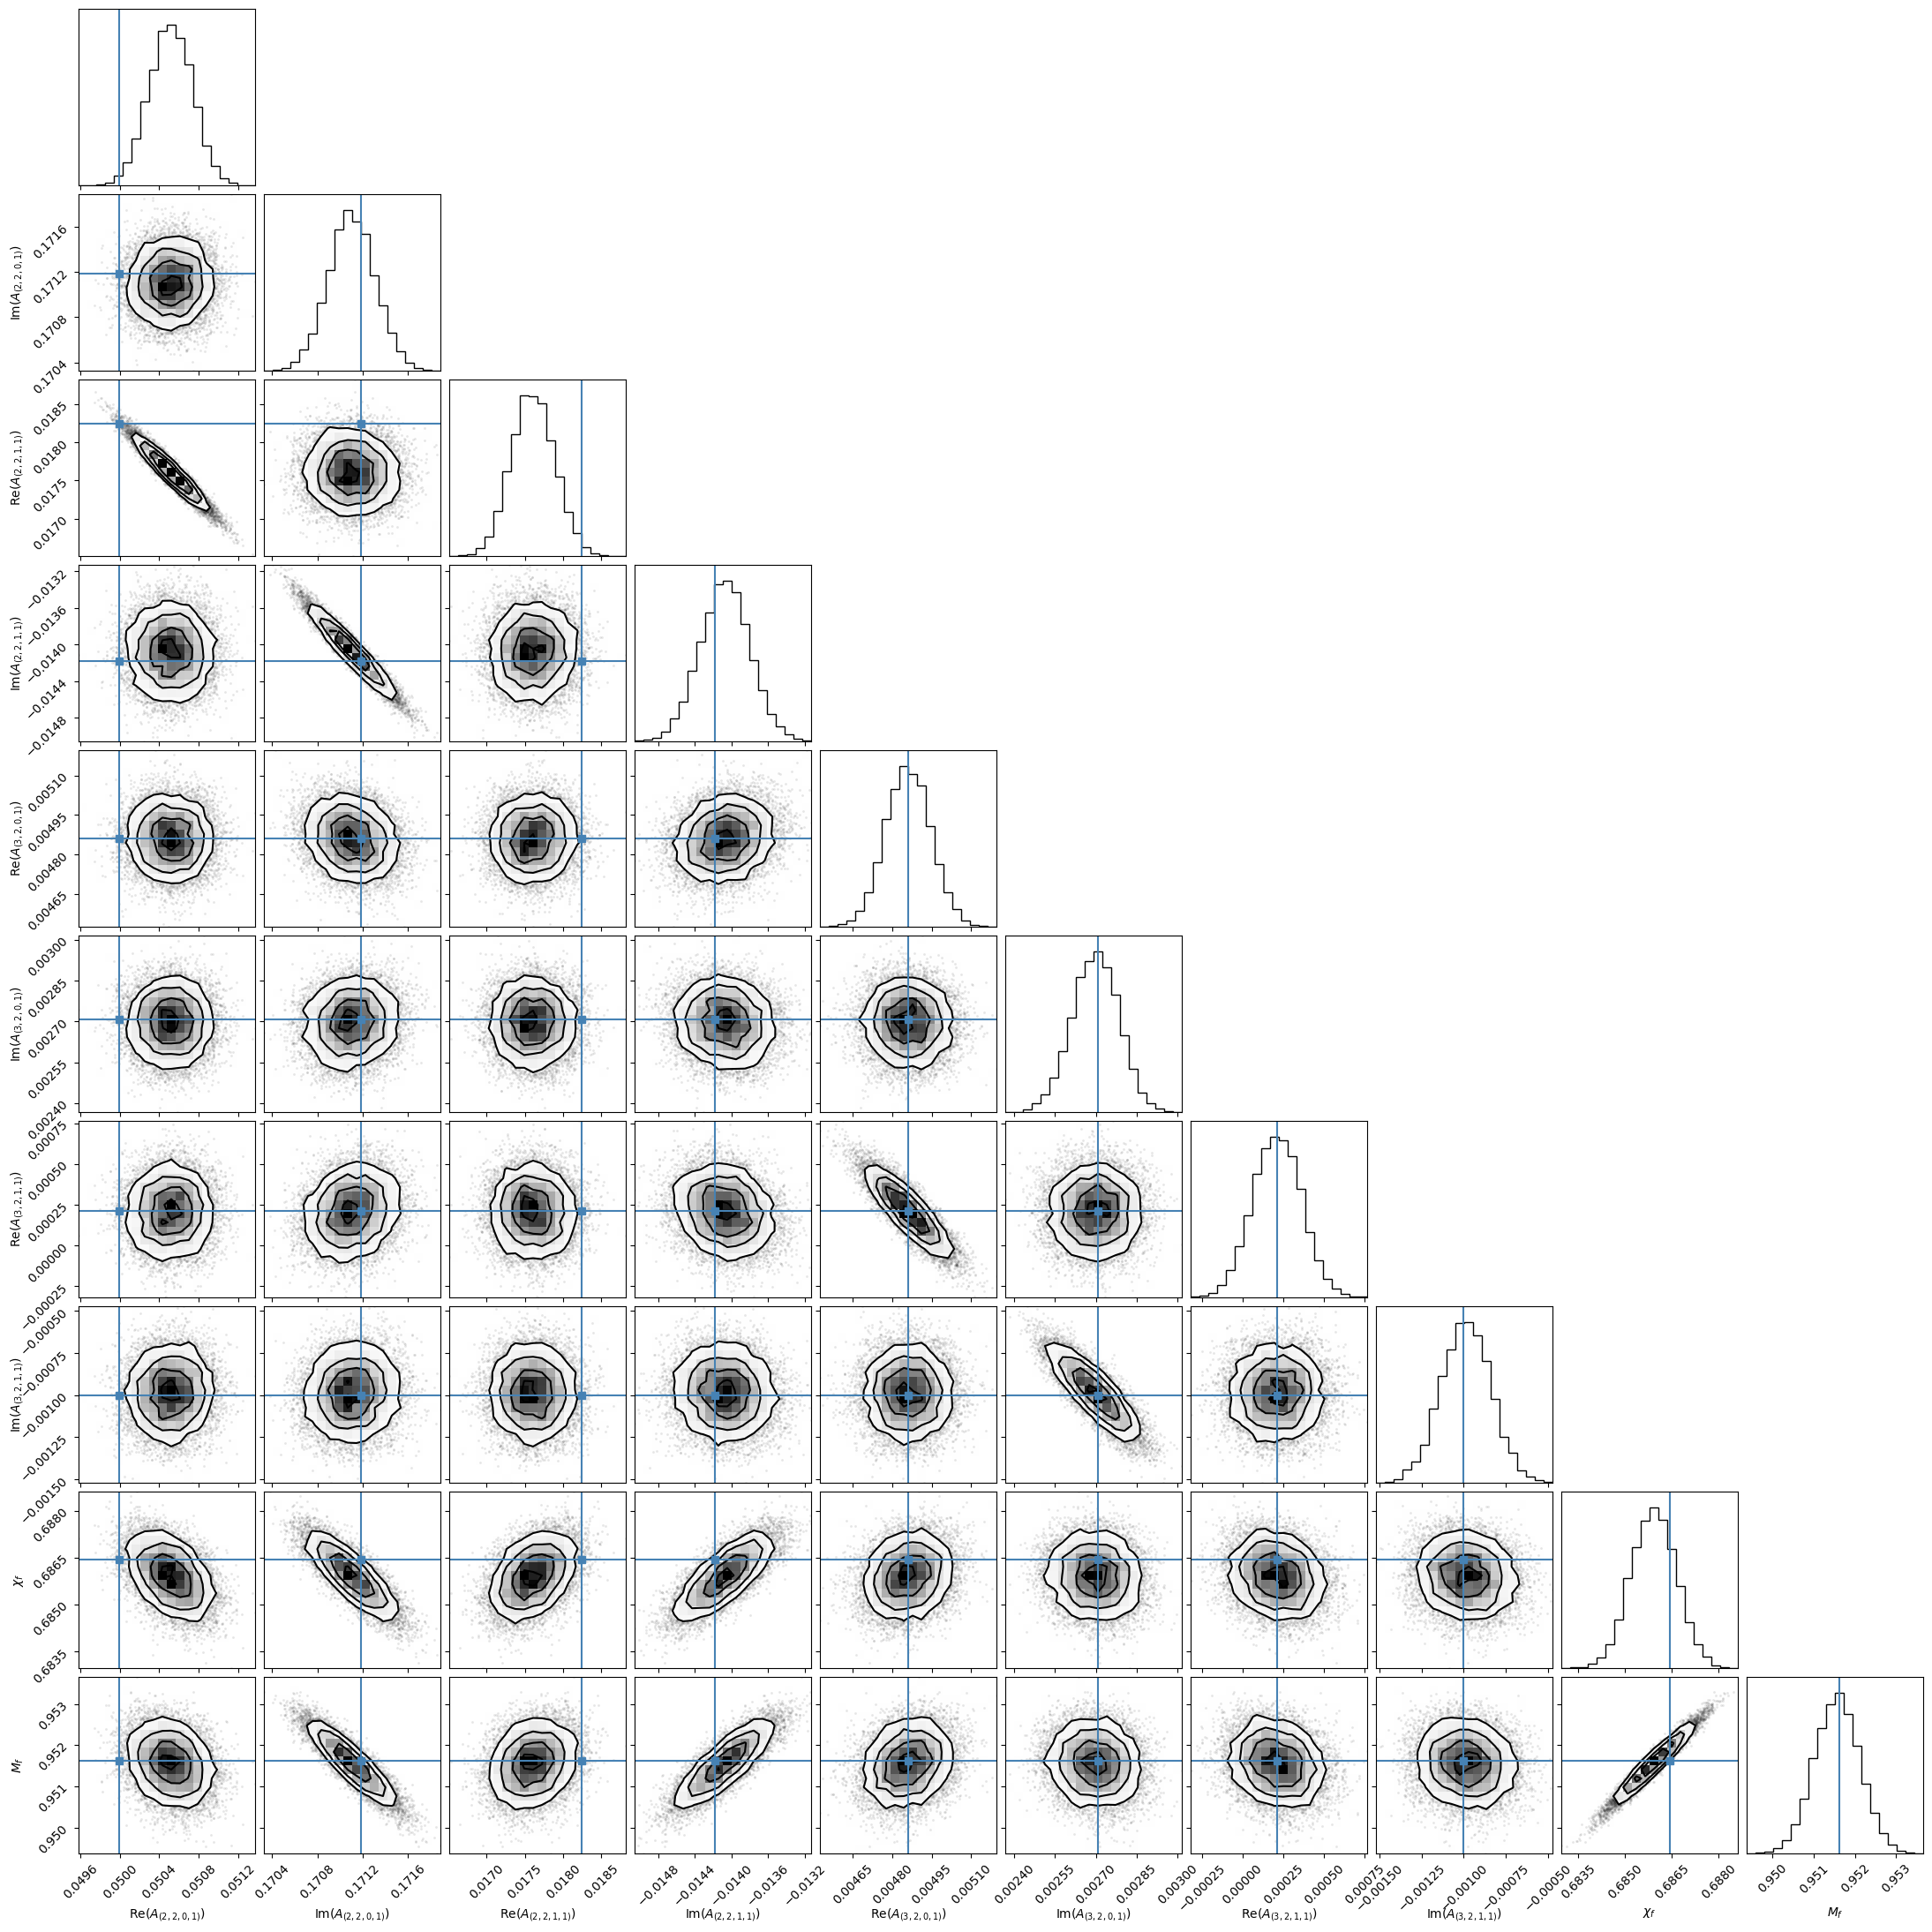

In [ ]:
labels = [
    r"$\mathrm{Re}(A_{(2,2,0,1)})$",
    r"$\mathrm{Im}(A_{(2,2,0,1)})$",
    r"$\mathrm{Re}(A_{(2,2,1,1)})$",
    r"$\mathrm{Im}(A_{(2,2,1,1)})$",
    r"$\mathrm{Re}(A_{(3,2,0,1)})$",
    r"$\mathrm{Im}(A_{(3,2,0,1)})$",
    r"$\mathrm{Re}(A_{(3,2,1,1)})$",
    r"$\mathrm{Im}(A_{(3,2,1,1)})$",
    r"$\chi_f$",
    r"$M_f$",
]

_ = corner.corner(
    samples,
    truths=true_params_full,
    labels=labels,
)

## Marginalisation 

Finally, we can marginalise over, for example, the amplitudes, to leave us with values for the mass and spin. Note that the marginalise function takes a parameter list as an argument rather than a qnm list. This is each QNM repeated twice, followed by "chif" and "Mf" as required.  

In [ ]:
parameters = [qnm for qnm in qnm_list for _ in range(2)] + ["chif", "Mf"]
parameter_choice = ["chif", "Mf"]
param_vals = [chif_mag_0, Mf_0]

marginal_mean, marginal_fisher = likelihood_funcs.marginalise(
    parameter_choice, parameters, mean_vector, fisher_matrix
)
marginal_covariance = np.linalg.inv(marginal_fisher)

In [ ]:
print(parameters)

[(2, 2, 0, 1), (2, 2, 0, 1), (2, 2, 1, 1), (2, 2, 1, 1), (3, 2, 0, 1), (3, 2, 0, 1), (3, 2, 1, 1), (3, 2, 1, 1), 'chif', 'Mf']


In [ ]:
samples = scipy.stats.multivariate_normal(
    marginal_mean, marginal_covariance, allow_singular=True
).rvs(size=10000)

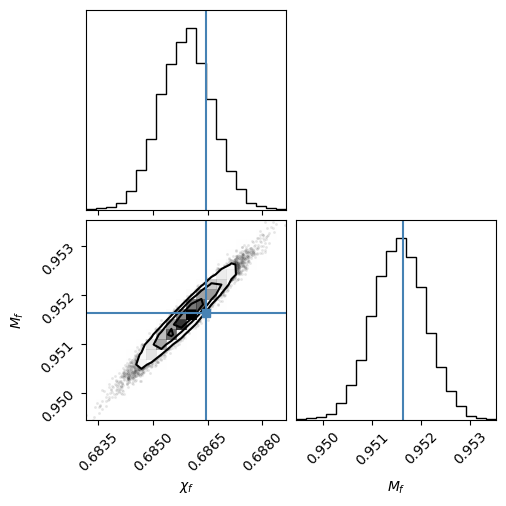

In [ ]:
labels = [r"$\chi_f$", r"$M_f$"]

_ = corner.corner(
    samples,
    truths=param_vals,
    labels=labels,
)

## Numerical error

TODO: include gaussian process kernel example. 